Guardar as imagens como um ficheiro svg para não perder qualidade na imagem.

### Import das bibliotecas a utilizar 

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

from scipy.stats import chi2_contingency

In [2]:
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,make_scorer, precision_score

from sklearn.utils import check_random_state

aleatorio = 774
random_state = check_random_state(aleatorio)
np.random.seed(aleatorio)
random.seed(aleatorio)

### Leitura Ficheiro

In [3]:
belgica= pd.read_csv("belgica_cleaned.csv")

In [4]:
belgica.shape

(4108, 15)

In [5]:
belgica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4108 entries, 0 to 4107
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PlayerName      4108 non-null   object 
 1   Oponent         4108 non-null   object 
 2   Tournament      4108 non-null   object 
 3   GroundNumerico  4108 non-null   int64  
 4   Prize           4108 non-null   int64  
 5   TournamentYear  4108 non-null   int64  
 6   NumeroSets      4108 non-null   int64  
 7   DiffIMC         4108 non-null   float64
 8   DiffAge         4108 non-null   int64  
 9   DiffRank        4108 non-null   float64
 10  QTDBelgas       4108 non-null   int64  
 11  Finals          4108 non-null   int64  
 12  SumMainHand     4108 non-null   int64  
 13  SumTrainer      4108 non-null   int64  
 14  TipoTorneio     4108 non-null   object 
dtypes: float64(2), int64(9), object(4)
memory usage: 481.5+ KB


# Partidas Melhores de 3

In [6]:
filtro = (belgica['TipoTorneio'] == "Melhor_de_3")
belgica3 = belgica[filtro]

In [7]:
belgica3.shape

(4033, 15)

In [8]:
len(belgica3[belgica3['NumeroSets']==2])

2703

In [9]:
len(belgica3[belgica3['NumeroSets']==3])

1330

## Tratamento final das variáveis

In [10]:
belgica3.head(3)

,PlayerName,Oponent,Tournament,GroundNumerico,Prize,TournamentYear,NumeroSets,DiffIMC,DiffAge,DiffRank,QTDBelgas,Finals,SumMainHand,SumTrainer,TipoTorneio
2,Andrei Pavel,Olivier Rochus,Mons,2,125000,2007,2,3.844451,7,-11.0,1,1,2,1,Melhor_de_3
4,Christophe Rochus,Olivier Rochus,Ostend,1,125000,1999,3,0.499366,3,15.0,2,0,2,2,Melhor_de_3
5,Josselin Ouanna,Olivier Rochus,Mons,2,148544,2009,3,1.400141,-5,64.0,1,0,2,2,Melhor_de_3


In [11]:
cols_to_drop=["PlayerName", "Oponent", "Tournament", 'TipoTorneio']
belgica3 = belgica3.drop(cols_to_drop,axis=1)

In [12]:
belgica3.columns

Index(['GroundNumerico', 'Prize', 'TournamentYear', 'NumeroSets', 'DiffIMC',
       'DiffAge', 'DiffRank', 'QTDBelgas', 'Finals', 'SumMainHand',
       'SumTrainer'],
      dtype='object')

In [13]:
VarNum = ['Prize', 'TournamentYear', 'DiffAge', 'DiffRank', 'DiffIMC']
VarCat = [i for i in belgica3.columns if i not in VarNum]

## Correlações

### Corelação Pearson

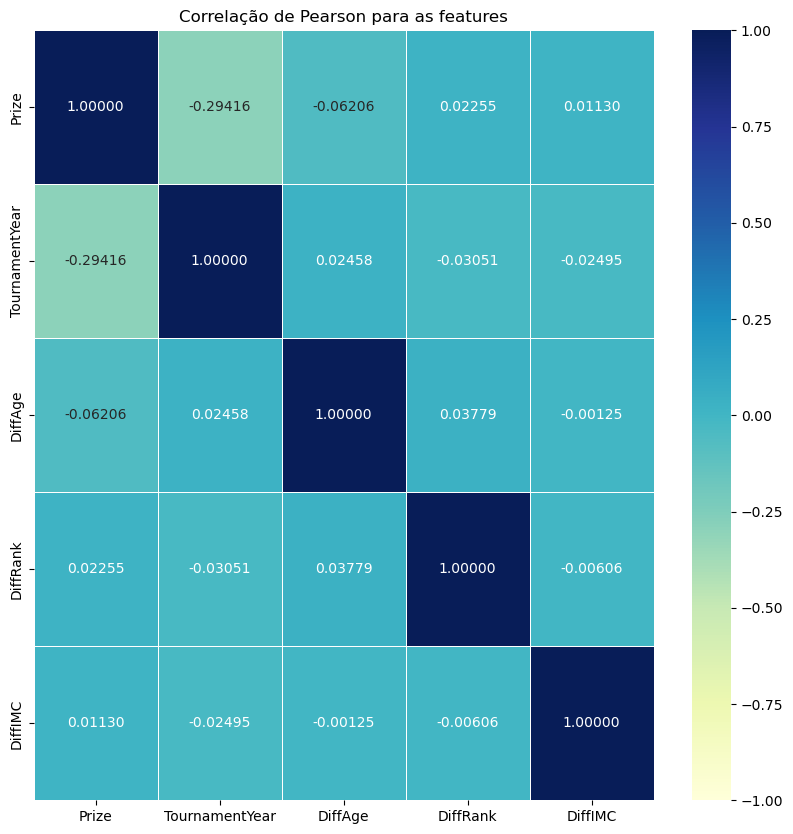

In [14]:
BelgicaCorr = belgica3[VarNum]

## plot correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
for col in BelgicaCorr.columns:
    if BelgicaCorr[col].dtype == "O":
         BelgicaCorr[col] = BelgicaCorr[col].factorize(sort=True)[0]
corr_matrix = BelgicaCorr.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.5f', cmap="YlGnBu", cbar=True, linewidths=0.5, ax=ax)
plt.title("Correlação de Pearson para as features")
plt.savefig("Pearson.svg", format="svg")

del BelgicaCorr

### ETA

In [15]:
VarNum

['Prize', 'TournamentYear', 'DiffAge', 'DiffRank', 'DiffIMC']

In [16]:
def eta_coefficient(y, x):
    categories, counts = np.unique(x, return_counts=True)
    l = len(categories)
    m = np.empty(l)
    qual = np.asarray(x)
    for k in range(l):
        m[k] = np.mean(y[qual == categories[k]])
    numerator = np.sum(counts * (m - np.mean(y))**2)
    denominator = np.sum((y - np.mean(y))**2)
    eta = np.sqrt(numerator / denominator)
    return eta

for i in VarNum:
    eta1 = eta_coefficient(belgica3['NumeroSets'], belgica3[str(i)])
    print(f"Coeficiente de Eta entre o NumeroSets e {i}: {eta1}")

Coeficiente de Eta entre o NumeroSets e Prize: 0.07502412523180677
Coeficiente de Eta entre o NumeroSets e TournamentYear: 0.12187450942034983
Coeficiente de Eta entre o NumeroSets e DiffAge: 0.12055971571634859
Coeficiente de Eta entre o NumeroSets e DiffRank: 0.6795061229491048
Coeficiente de Eta entre o NumeroSets e DiffIMC: 0.7654001481831414


### VCramer

In [17]:
VarCat

['GroundNumerico',
 'NumeroSets',
 'QTDBelgas',
 'Finals',
 'SumMainHand',
 'SumTrainer']

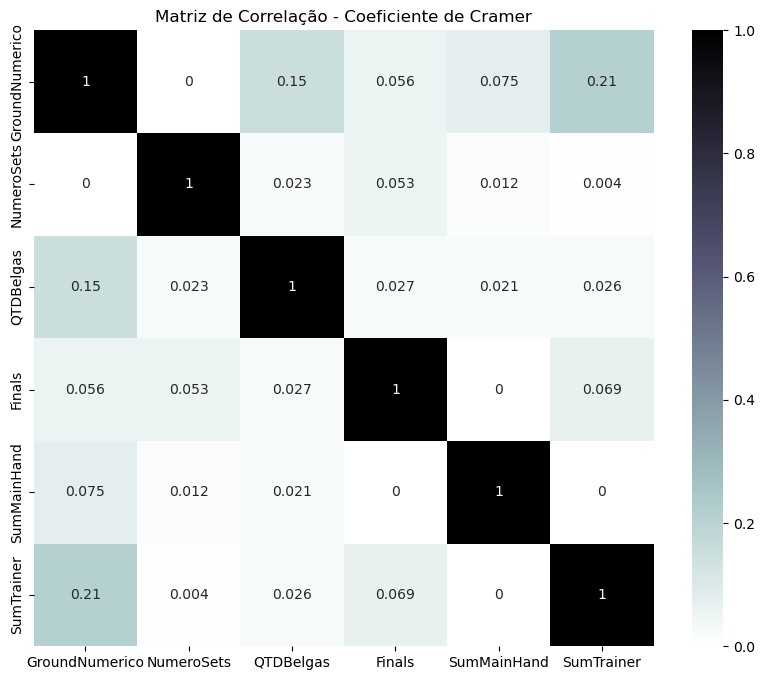

In [18]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    cramer_v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    return cramer_v

# Converter colunas categóricas para o tipo 'category' (se necessário)
for col in VarCat:
    belgica3[col] = belgica3[col].astype('category')

# Calcular a matriz de correlação
corr_matrix = pd.DataFrame(index=VarCat, columns=VarCat)
for col1 in VarCat:
    for col2 in VarCat:
        corr_matrix.loc[col1, col2] = cramers_v(belgica3[col1], belgica3[col2])

# Remover colunas com valores ausentes na matriz de correlação
corr_matrix = corr_matrix.dropna(axis=1, how='any')

# Plotar o heatmap
plt.figure(figsize=(10, 8))
# rocket, coolwarm
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='bone_r')
plt.title('Matriz de Correlação - Coeficiente de Cramer')
plt.savefig("Cramer.svg", format="svg")
plt.show()

In [19]:
# Cramer é entre variáveis qualitativas

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

for i in VarCat:
    if i != 'NumeroSets':
        v_cramer = cramers_v(belgica3['NumeroSets'], belgica3[str(i)])
        print(f"Coeficiente de VCramer entre o NumeroSets e {i}: {v_cramer}")

Coeficiente de VCramer entre o NumeroSets e GroundNumerico: 0.0
Coeficiente de VCramer entre o NumeroSets e QTDBelgas: 0.023191024835393412
Coeficiente de VCramer entre o NumeroSets e Finals: 0.05318934851851
Coeficiente de VCramer entre o NumeroSets e SumMainHand: 0.01238689994521305
Coeficiente de VCramer entre o NumeroSets e SumTrainer: 0.0040123542589560355


## Modelos

In [20]:
belgica3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4033 entries, 2 to 4107
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   GroundNumerico  4033 non-null   category
 1   Prize           4033 non-null   int64   
 2   TournamentYear  4033 non-null   int64   
 3   NumeroSets      4033 non-null   category
 4   DiffIMC         4033 non-null   float64 
 5   DiffAge         4033 non-null   int64   
 6   DiffRank        4033 non-null   float64 
 7   QTDBelgas       4033 non-null   category
 8   Finals          4033 non-null   category
 9   SumMainHand     4033 non-null   category
 10  SumTrainer      4033 non-null   category
dtypes: category(6), float64(2), int64(3)
memory usage: 213.4 KB


In [21]:
belgica_train, belgica_test = model_selection.train_test_split(belgica3, test_size=0.3,random_state=random_state)

print("train:", belgica_train.shape)
print("test:", belgica_test.shape)

train: (2823, 11)
test: (1210, 11)


In [22]:
belgica_names = [i for i in belgica3.columns if i != "NumeroSets"]
X_train = belgica_train[belgica_names].values

y_train = belgica_train["NumeroSets"].values
X_test = belgica_test[belgica_names].values
y_test = belgica_test["NumeroSets"].values

### Regressão Logística

In [23]:
### logistic regression

lr = LogisticRegression(max_iter = 2000,random_state=random_state)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.67433628 0.67433628 0.67787611 0.67553191 0.67553191]
0.6755225004707212


### KNN

In [24]:
### KNN

knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.59646018 0.59115044 0.62654867 0.61170213 0.62056738]
0.6092857591162995


C:\Users\diogo\scoop\apps\anaconda3\2022.10\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\diogo\scoop\apps\anaconda3\2022.10\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

### RandomForestClassifier

In [25]:
model = RandomForestClassifier(random_state=random_state)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=RandomState(MT19937) at 0x1BA2E96D140)

In [26]:
y_pred=model.predict(X_test)
print(y_pred)
np.unique(y_pred)

[2 2 2 ... 2 2 2]


array([2, 3], dtype=int64)

In [27]:
probs = model.predict_proba(X_test)[:, 1]
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print("Recall: ",metrics.recall_score(y_test,y_pred, zero_division=1, pos_label=2))
print("Precision:",metrics.precision_score(y_test,y_pred, zero_division=1, pos_label=2))
auc = roc_auc_score(y_test, probs)
print("roc_auc_score:", auc)

Accuracy: 0.6330578512396694
Recall:  0.8955974842767296
Precision: 0.6635601118359739
roc_auc_score: 0.5158354171402592


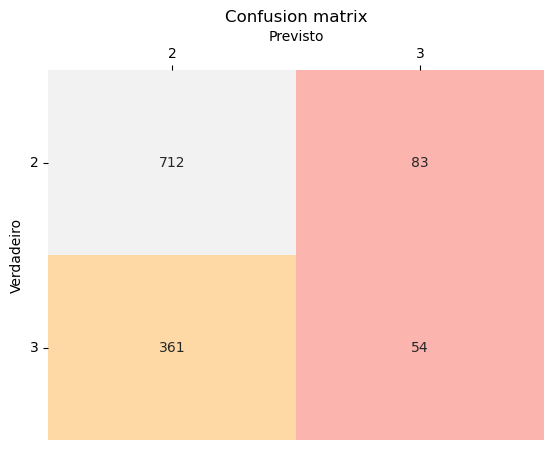

In [28]:
# Obtendo as classes únicas de y_test e y_pred
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_pred, labels=classes[::1])
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Pastel1, cbar=False)
ax.set(xlabel="Previsto", ylabel="Verdadeiro", title="Confusion matrix")
ax.xaxis.set_label_position("top")  # Posiciona os rótulos dos valores previstos em cima
ax.xaxis.set_ticks_position("top")  # Posiciona os ticks dos valores previstos em cima
ax.yaxis.set_ticks_position("left")  # Posiciona os ticks das classes à esquerda
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes[::1], rotation=0)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes[::1], rotation=0)  # Inverte a ordem dos rótulos das classes
plt.show()

<BarContainer object of 10 artists>

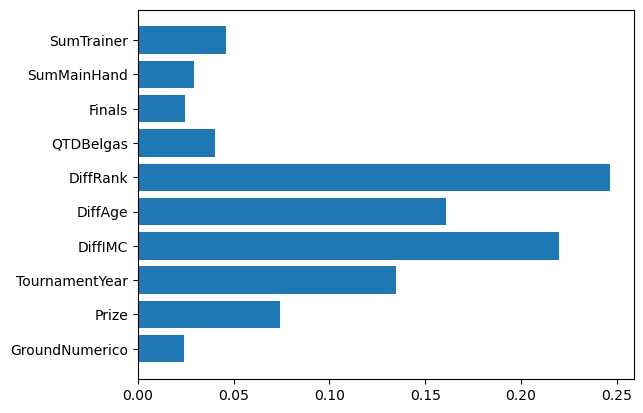

In [29]:
plt.barh(belgica_names, model.feature_importances_)

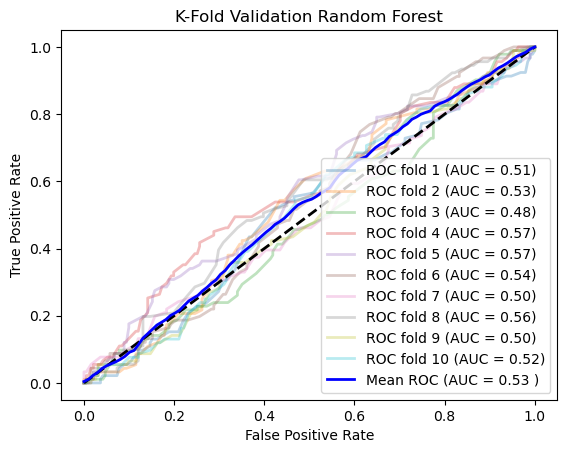

In [30]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    fpr, tpr, t = metrics.roc_curve(y_train[test], prediction[:, 1], pos_label=3) # Classe 2 como positiva
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1

plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation Random Forest')
plt.legend(loc="lower right")
plt.savefig("K-fold_RF1.svg", format="svg")
plt.show()

Vamos aplicar o mesmo modelo mas sem o GroundNumerico, visto que tem correlação nula com o alvo e que não teve muita importância neste modelo.

### RandomForestClassifier (Sem o GroundNumerico)

In [31]:
belgica_names = [i for i in belgica3.columns if i != "NumeroSets" and i != "GroundNumerico"] # retirar ground
# definir os conjuntos
X_train = belgica_train[belgica_names].values
y_train = belgica_train["NumeroSets"].values
X_test = belgica_test[belgica_names].values
y_test = belgica_test["NumeroSets"].values

In [32]:
model = RandomForestClassifier(random_state=random_state)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=RandomState(MT19937) at 0x1BA2E96D140)

In [33]:
y_pred=model.predict(X_test)
print(y_pred)
np.unique(y_pred)

[2 2 2 ... 2 2 2]


array([2, 3], dtype=int64)

In [34]:
probs = model.predict_proba(X_test)[:, 1]
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print("Recall: ",metrics.recall_score(y_test,y_pred, zero_division=1, pos_label=2))
print("Precision:",metrics.precision_score(y_test,y_pred, zero_division=1, pos_label=2))
auc = roc_auc_score(y_test, probs)
print("roc_auc_score:", auc)

Accuracy: 0.6347107438016529
Recall:  0.9018867924528302
Precision: 0.6632747456059205
roc_auc_score: 0.5117587330453891


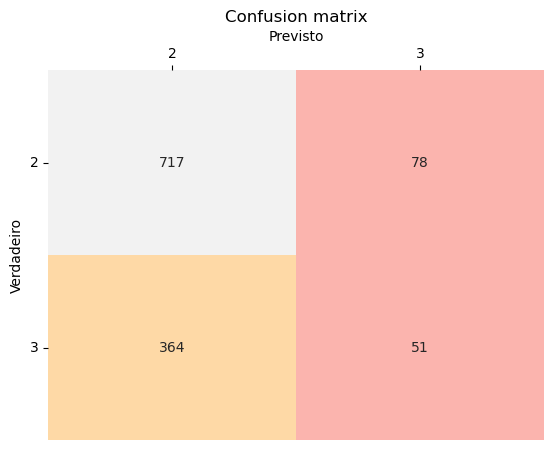

In [35]:
# Obtendo as classes únicas de y_test e y_pred
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_pred, labels=classes[::1])
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Pastel1, cbar=False)
ax.set(xlabel="Previsto", ylabel="Verdadeiro", title="Confusion matrix")
ax.xaxis.set_label_position("top")  # Posiciona os rótulos dos valores previstos em cima
ax.xaxis.set_ticks_position("top")  # Posiciona os ticks dos valores previstos em cima
ax.yaxis.set_ticks_position("left")  # Posiciona os ticks das classes à esquerda
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes[::1], rotation=0)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes[::1], rotation=0)  # Inverte a ordem dos rótulos das classes
plt.show()

<BarContainer object of 9 artists>

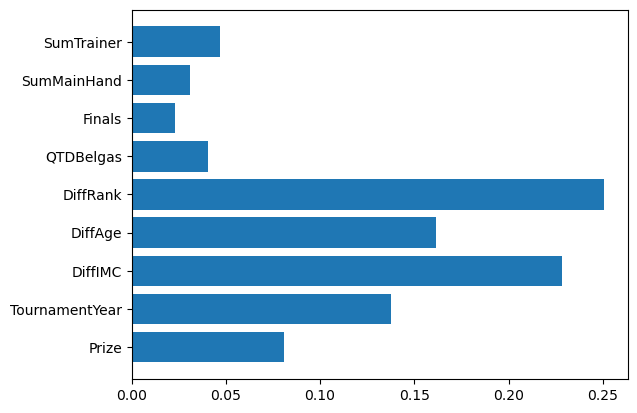

In [36]:
plt.barh(belgica_names, model.feature_importances_)

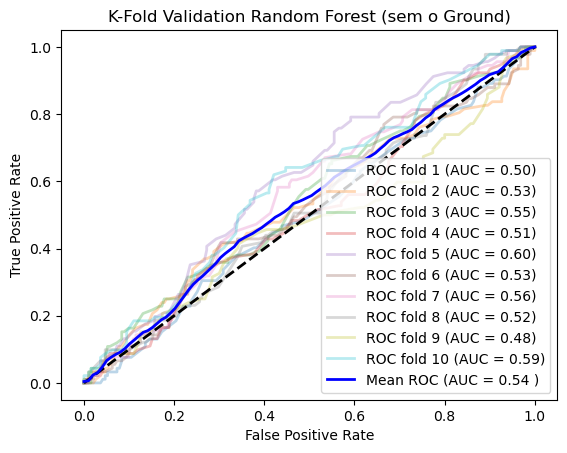

In [37]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    fpr, tpr, t = metrics.roc_curve(y_train[test], prediction[:, 1], pos_label=3) # Classe 2 como positiva
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1

plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation Random Forest (sem o Ground)')
plt.legend(loc="lower right")
plt.savefig("K-fold_RF2_noground.svg", format="svg")
plt.show()

Os resultados do modelo pareceram melhores e por isso iremos manter com os modelos sem o GroundNumerico como feature.

### GradientBoostingClassifier

In [38]:
model = GradientBoostingClassifier(random_state=random_state)
model.fit(X_train,y_train)

GradientBoostingClassifier(random_state=RandomState(MT19937) at 0x1BA2E96D140)

In [39]:
y_pred=model.predict(X_test)
print(y_pred)
np.unique(y_pred)

[2 2 2 ... 2 2 2]


array([2, 3], dtype=int64)

In [40]:
probs = model.predict_proba(X_test)[:, 1]
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print("Recall: ",metrics.recall_score(y_test,y_pred, zero_division=1, pos_label=2))
print("Precision:",metrics.precision_score(y_test,y_pred, zero_division=1, pos_label=2))
auc = roc_auc_score(y_test, probs)
print("roc_auc_score:", auc)

Accuracy: 0.6528925619834711
Recall:  0.9723270440251572
Precision: 0.6601195559350982
roc_auc_score: 0.5338031370766083


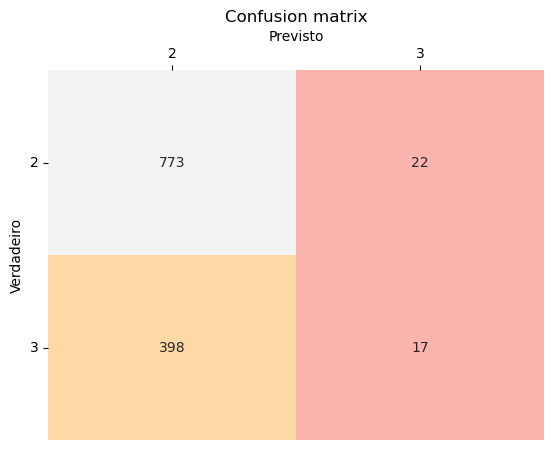

In [41]:
# Obtendo as classes únicas de y_test e y_pred
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_pred, labels=classes[::1])
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Pastel1, cbar=False)
ax.set(xlabel="Previsto", ylabel="Verdadeiro", title="Confusion matrix")
ax.xaxis.set_label_position("top")  # Posiciona os rótulos dos valores previstos em cima
ax.xaxis.set_ticks_position("top")  # Posiciona os ticks dos valores previstos em cima
ax.yaxis.set_ticks_position("left")  # Posiciona os ticks das classes à esquerda
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes[::1], rotation=0)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes[::1], rotation=0)  # Inverte a ordem dos rótulos das classes
plt.show()

<BarContainer object of 9 artists>

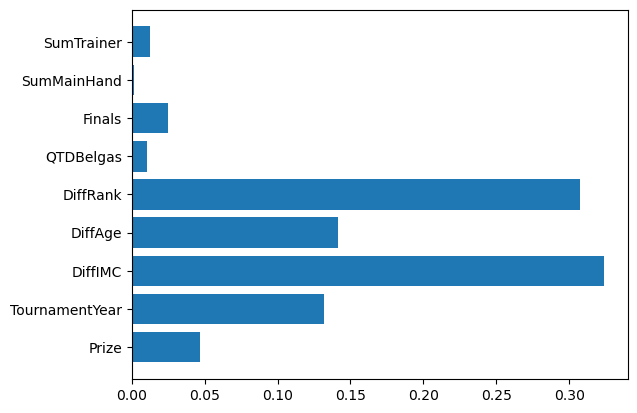

In [42]:
plt.barh(belgica_names, model.feature_importances_)

#### Tentativa de melhorar o modelo

##### Atualizar os hiperparâmetros

In [43]:
# Valores dados no bloco de código anterior
model = GradientBoostingClassifier(subsample = 0.95, n_estimators = 1250, min_samples_split = 3, min_samples_leaf = 3, max_features = 4, max_depth = 3, learning_rate = 0.005, random_state=random_state)
model.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.005, max_features=4,
                           min_samples_leaf=3, min_samples_split=3,
                           n_estimators=1250,
                           random_state=RandomState(MT19937) at 0x1BA2E96D140,
                           subsample=0.95)

In [44]:
y_pred=model.predict(X_test)
print(y_pred)
np.unique(y_pred)

[2 2 2 ... 2 2 2]


array([2, 3], dtype=int64)

In [45]:
probs = model.predict_proba(X_test)[:, 1]
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print("Recall: ",metrics.recall_score(y_test,y_pred, zero_division=1, pos_label=2))
print("Precision:",metrics.precision_score(y_test,y_pred, zero_division=1, pos_label=2))
auc = roc_auc_score(y_test, probs)
print("roc_auc_score:", auc)

Accuracy: 0.6528925619834711
Recall:  0.9874213836477987
Precision: 0.6569037656903766
roc_auc_score: 0.5417064484352505


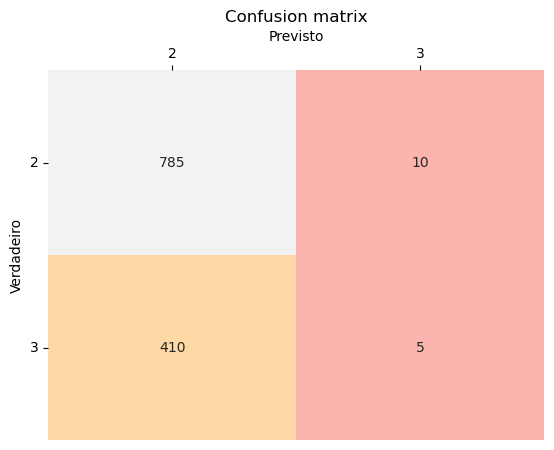

In [46]:
# Obtendo as classes únicas de y_test e y_pred
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_pred, labels=classes[::1])
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Pastel1, cbar=False)
ax.set(xlabel="Previsto", ylabel="Verdadeiro", title="Confusion matrix")
ax.xaxis.set_label_position("top")  # Posiciona os rótulos dos valores previstos em cima
ax.xaxis.set_ticks_position("top")  # Posiciona os ticks dos valores previstos em cima
ax.yaxis.set_ticks_position("left")  # Posiciona os ticks das classes à esquerda
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes[::1], rotation=0)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes[::1], rotation=0)  # Inverte a ordem dos rótulos das classes
plt.show()

<BarContainer object of 9 artists>

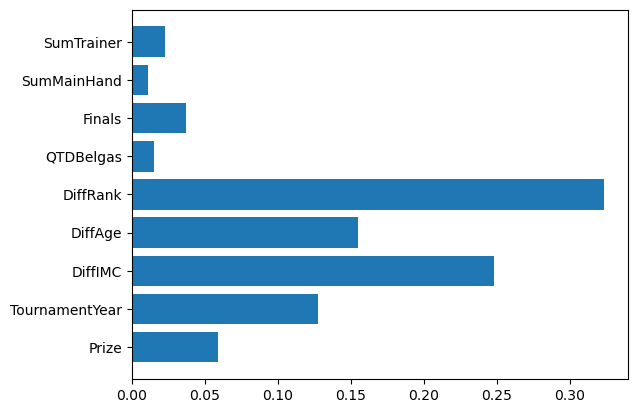

In [47]:
plt.barh(belgica_names, model.feature_importances_)

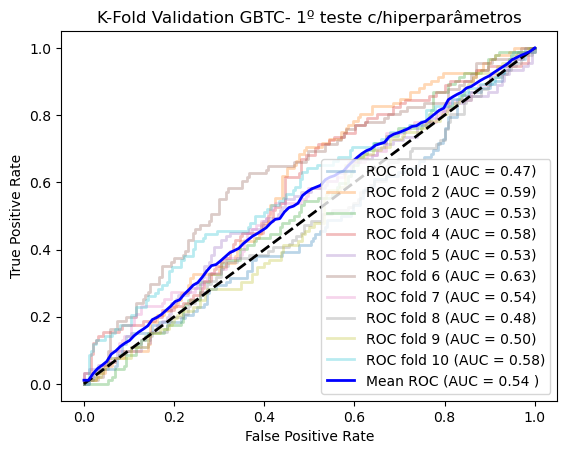

In [48]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    fpr, tpr, t = metrics.roc_curve(y_train[test], prediction[:, 1], pos_label = 3) # Classe 2 como positiva
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1

plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation GBTC- 1º teste c/hiperparâmetros')
plt.legend(loc="lower right")
plt.savefig("K-fold_GBT1.svg", format="svg")
plt.show()

In [49]:
# Valores dados no bloco de código anterior
model = GradientBoostingClassifier(subsample = 0.95, n_estimators = 1250, min_samples_split = 8, min_samples_leaf = 1, max_features = 2, max_depth = 6,learning_rate = 0.005, random_state=random_state)
model.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.005, max_depth=6, max_features=2,
                           min_samples_split=8, n_estimators=1250,
                           random_state=RandomState(MT19937) at 0x1BA2E96D140,
                           subsample=0.95)

In [50]:
y_pred=model.predict(X_test)
print(y_pred)
np.unique(y_pred)

[2 2 2 ... 2 2 2]


array([2, 3], dtype=int64)

In [51]:
probs = model.predict_proba(X_test)[:, 1]
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))
print("Recall: ",metrics.recall_score(y_test,y_pred, zero_division=1, pos_label=2))
print("Precision:",metrics.precision_score(y_test,y_pred, zero_division=1, pos_label=2))
auc = roc_auc_score(y_test, probs)
print("roc_auc_score:", auc)

Accuracy: 0.6495867768595042
Recall:  0.9610062893081761
Precision: 0.6603284356093345
roc_auc_score: 0.5220353110555429


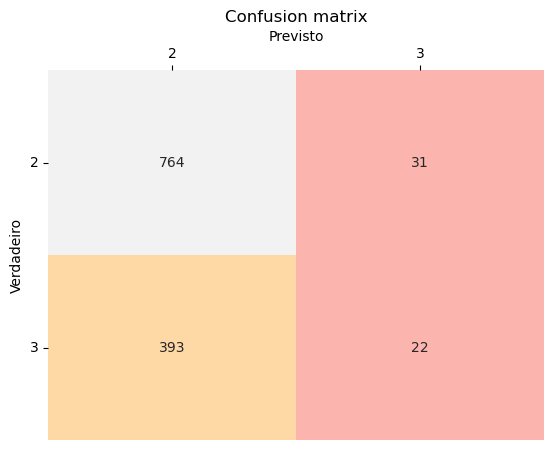

In [52]:
# Obtendo as classes únicas de y_test e y_pred
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_pred, labels=classes[::1])
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Pastel1, cbar=False)
ax.set(xlabel="Previsto", ylabel="Verdadeiro", title="Confusion matrix")
ax.xaxis.set_label_position("top")  # Posiciona os rótulos dos valores previstos em cima
ax.xaxis.set_ticks_position("top")  # Posiciona os ticks dos valores previstos em cima
ax.yaxis.set_ticks_position("left")  # Posiciona os ticks das classes à esquerda
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes[::1], rotation=0)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes[::1], rotation=0)  # Inverte a ordem dos rótulos das classes
plt.show()

<BarContainer object of 9 artists>

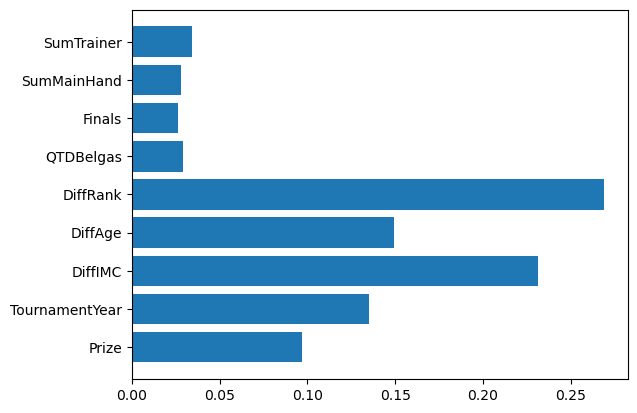

In [53]:
plt.barh(belgica_names, model.feature_importances_)

##### K-Folder

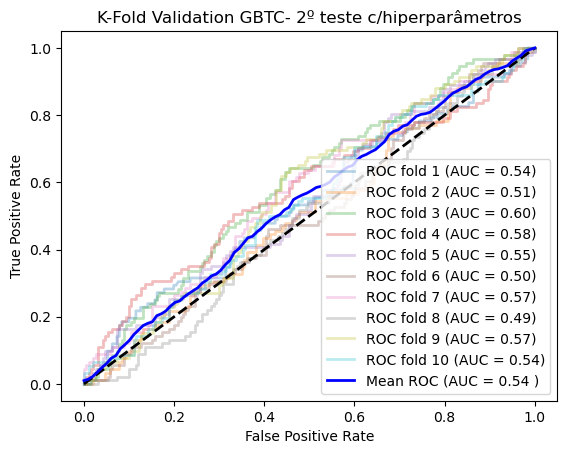

In [54]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    fpr, tpr, t = metrics.roc_curve(y_train[test], prediction[:, 1], pos_label=3) # Classe 2 como positiva
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1

plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation GBTC- 2º teste c/hiperparâmetros')
plt.legend(loc="lower right")
plt.savefig("K-fold_GBT2.svg", format="svg")
plt.show()

Teste com K-fold visualizando as outras métricas.

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Melhor modelo

# Definição do número de folds para o k-fold
n_splits = 10

# Criação do objeto KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Criação do modelo GradientBoostingClassifier
model = model = GradientBoostingClassifier(subsample = 0.95, n_estimators = 1250, min_samples_split = 3, min_samples_leaf = 3, max_features = 4, max_depth = 3, learning_rate = 0.005, random_state=random_state)
# Listas para armazenar as métricas de avaliação
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Loop sobre os folds do k-fold
for train_index, test_index in kf.split(belgica_train):
    X_train, X_val = belgica_train.iloc[train_index][belgica_names], belgica_train.iloc[test_index][belgica_names]
    y_train, y_val = belgica_train.iloc[train_index]['NumeroSets'], belgica_train.iloc[test_index]['NumeroSets']
    
    # Treinamento do modelo
    model.fit(X_train, y_train)
    
    # Predição nos dados de validação
    y_pred = model.predict(X_val)
    
    # Cálculo das métricas de avaliação
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro', zero_division=1, labels=[2])
    recall = recall_score(y_val, y_pred, average='macro', zero_division=1, labels=[2])
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=1, labels=[2])
    
    # Adição das métricas às listas correspondentes
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Cálculo das médias das métricas de avaliação
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1_scores)

# Impressão das médias das métricas de avaliação
print("Mean Accuracy:", mean_accuracy)
print("Mean Precision:", mean_precision)
print("Mean Recall:", mean_recall)
print("Mean F1-score:", mean_f1)

Mean Accuracy: 0.6740846552890759
Mean Precision: 0.6773006907431023
Mean Recall: 0.9897133366947575
Mean F1-score: 0.8037333688069902


# Partidas Melhores de 5

In [56]:
filtro = (belgica['TipoTorneio'] == "Melhor_de_5")
belgica5 = belgica[filtro]

In [57]:
belgica5.shape

(75, 15)

In [58]:
cols_to_drop=["PlayerName", "Oponent", "Tournament", 'TipoTorneio']
belgica5 = belgica5.drop(cols_to_drop,axis=1)

In [59]:
belgica5.columns

Index(['GroundNumerico', 'Prize', 'TournamentYear', 'NumeroSets', 'DiffIMC',
       'DiffAge', 'DiffRank', 'QTDBelgas', 'Finals', 'SumMainHand',
       'SumTrainer'],
      dtype='object')

In [60]:
VarNum = ['Prize','TournamentYear', 'DiffAge', 'DiffRank', 'DiffIMC']
VarCat = [i for i in belgica5.columns if i not in VarNum]

In [61]:
belgica5['NumeroSets'].unique()

array([3, 5, 4], dtype=int64)

## Correlações

### Corelação Pearson

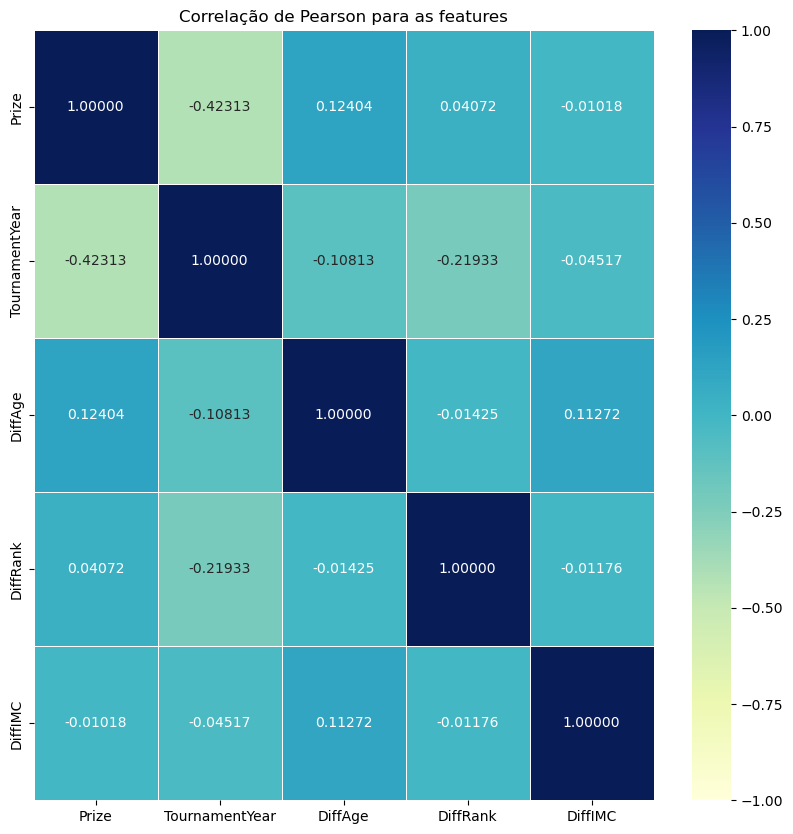

In [62]:
BelgicaCorr = belgica5[VarNum]

## plot correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
for col in BelgicaCorr.columns:
    if BelgicaCorr[col].dtype == "O":
         BelgicaCorr[col] = BelgicaCorr[col].factorize(sort=True)[0]
corr_matrix = BelgicaCorr.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.5f', cmap="YlGnBu", cbar=True, linewidths=0.5, ax=ax)
plt.title("Correlação de Pearson para as features")

del BelgicaCorr

### VCramer

In [63]:
belgica5.columns

Index(['GroundNumerico', 'Prize', 'TournamentYear', 'NumeroSets', 'DiffIMC',
       'DiffAge', 'DiffRank', 'QTDBelgas', 'Finals', 'SumMainHand',
       'SumTrainer'],
      dtype='object')

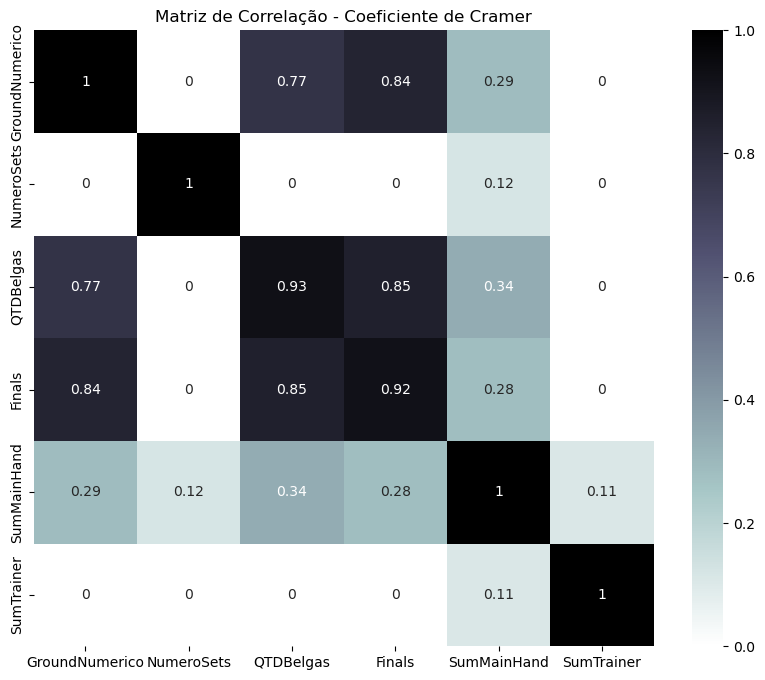

In [64]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    cramer_v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    return cramer_v

# Converter colunas categóricas para o tipo 'category' (se necessário)
for col in VarCat:
    belgica5[col] = belgica5[col].astype('category')

# Calcular a matriz de correlação
corr_matrix = pd.DataFrame(index=VarCat, columns=VarCat)
for col1 in VarCat:
    for col2 in VarCat:
        corr_matrix.loc[col1, col2] = cramers_v(belgica5[col1], belgica5[col2])

# Remover colunas com valores ausentes na matriz de correlação
corr_matrix = corr_matrix.dropna(axis=1, how='any')

# Plotar o heatmap
plt.figure(figsize=(10, 8))
# rocket, coolwarm
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='bone_r')
plt.title('Matriz de Correlação - Coeficiente de Cramer')
plt.show()

In [65]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

for i in VarCat:
    if i != 'NumeroSets':
        v_cramer = cramers_v(belgica5['NumeroSets'], belgica5[str(i)])
        print(f"Coeficiente de VCramer entre o NumeroSets e {i}: {v_cramer}")

Coeficiente de VCramer entre o NumeroSets e GroundNumerico: 0.0
Coeficiente de VCramer entre o NumeroSets e QTDBelgas: 0.0
Coeficiente de VCramer entre o NumeroSets e Finals: 0.0
Coeficiente de VCramer entre o NumeroSets e SumMainHand: 0.12056735001920107
Coeficiente de VCramer entre o NumeroSets e SumTrainer: 0.0


### ETA

In [66]:
VarNum

['Prize', 'TournamentYear', 'DiffAge', 'DiffRank', 'DiffIMC']

In [67]:
def eta_coefficient(x, y):
    categories, counts = np.unique(x, return_counts=True)
    l = len(categories)
    m = np.empty(l)
    qual = np.asarray(x)
    for k in range(l):
        m[k] = np.mean(y[qual == categories[k]])
    numerator = np.sum(counts * (m - np.mean(y))**2)
    denominator = np.sum((y - np.mean(y))**2)
    eta = np.sqrt(numerator / denominator)
    return eta

for i in VarNum:
    eta1 = eta_coefficient(belgica5['NumeroSets'], belgica5[str(i)])
    print(f"Coeficiente de Eta entre o NumeroSets e {i}: {eta1}")

Coeficiente de Eta entre o NumeroSets e Prize: 0.06998289002575753
Coeficiente de Eta entre o NumeroSets e TournamentYear: 0.08429682124000855
Coeficiente de Eta entre o NumeroSets e DiffAge: 0.050787450018337
Coeficiente de Eta entre o NumeroSets e DiffRank: 0.1858870899082243
Coeficiente de Eta entre o NumeroSets e DiffIMC: 0.17890693161744534


## Modelos

In [68]:
belgica5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 4068
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   GroundNumerico  75 non-null     category
 1   Prize           75 non-null     int64   
 2   TournamentYear  75 non-null     int64   
 3   NumeroSets      75 non-null     category
 4   DiffIMC         75 non-null     float64 
 5   DiffAge         75 non-null     int64   
 6   DiffRank        75 non-null     float64 
 7   QTDBelgas       75 non-null     category
 8   Finals          75 non-null     category
 9   SumMainHand     75 non-null     category
 10  SumTrainer      75 non-null     category
dtypes: category(6), float64(2), int64(3)
memory usage: 4.7 KB


In [69]:
belgica_train, belgica_test = model_selection.train_test_split(belgica5, test_size=0.3,random_state=random_state)

print("train:", belgica_train.shape)
print("test:", belgica_test.shape)

train: (52, 11)
test: (23, 11)


In [70]:
belgica_names = [i for i in belgica5.columns if i != "NumeroSets"]
X_train = belgica_train[belgica_names].values

y_train = belgica_train["NumeroSets"].values
X_test = belgica_test[belgica_names].values
y_test = belgica_test["NumeroSets"].values

#### RandomForestClassifier

In [71]:
model = RandomForestClassifier(random_state=random_state)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=RandomState(MT19937) at 0x1BA2E96D140)

In [72]:
y_pred=model.predict(X_test)
print(y_pred)
np.unique(y_pred)

[5 3 5 5 4 5 3 3 3 3 3 3 3 5 3 5 3 5 4 3 3 3 5]


array([3, 4, 5], dtype=int64)

In [73]:
probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
print("Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
auc = metrics.roc_auc_score(y_test, probs, multi_class='ovr')
print("roc_auc_score:", auc)

Accuracy: 0.34782608695652173
Recall: 0.33928571428571425
Precision: 0.3942307692307692
roc_auc_score: 0.48392857142857143


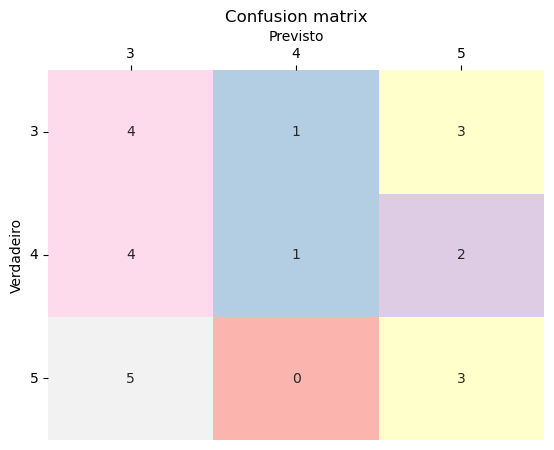

In [74]:
# Obtendo as classes únicas de y_test e y_pred
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_pred, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Pastel1, cbar=False)
ax.set(xlabel="Previsto", ylabel="Verdadeiro", title="Confusion matrix")
ax.xaxis.set_label_position("top")  # Posiciona os rótulos dos valores previstos em cima
ax.xaxis.set_ticks_position("top")  # Posiciona os ticks dos valores previstos em cima
ax.yaxis.set_ticks_position("left")  # Posiciona os ticks das classes à esquerda
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=0)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=0)  # Inverte a ordem dos rótulos das classes
plt.show()

<BarContainer object of 10 artists>

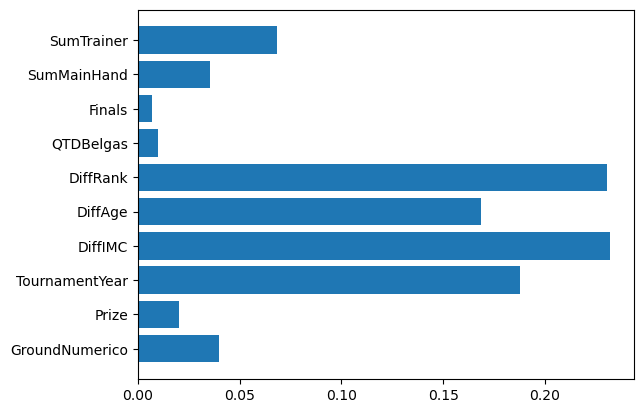

In [75]:
plt.barh(belgica_names, model.feature_importances_)

#### GradientBoostingClassifier

In [76]:
model = GradientBoostingClassifier(loss="deviance",random_state=random_state)
model.fit(X_train,y_train)

GradientBoostingClassifier(random_state=RandomState(MT19937) at 0x1BA2E96D140)

In [77]:
y_pred=model.predict(X_test)
print(y_pred)
np.unique(y_pred)

[3 3 4 3 5 5 5 3 5 3 5 4 3 5 4 5 4 5 3 3 3 5 5]


array([3, 4, 5], dtype=int64)

In [78]:
probs = model.predict_proba(X_test)
y_pred = model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
print("Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
auc = metrics.roc_auc_score(y_test, probs, multi_class='ovr')
print("roc_auc_score:", auc)

Accuracy: 0.30434782608695654
Recall: 0.2976190476190476
Precision: 0.2981481481481481
roc_auc_score: 0.48412698412698413


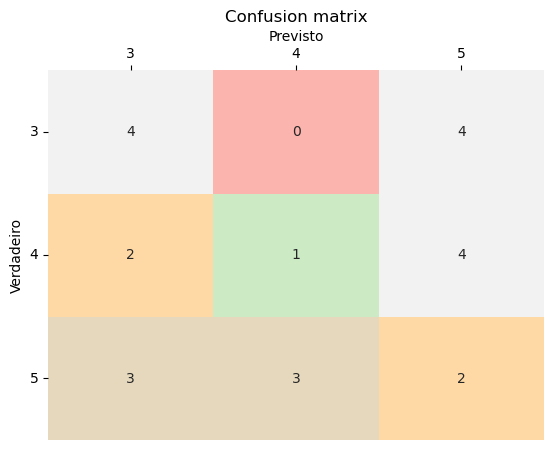

In [79]:
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, y_pred, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Pastel1, cbar=False)
ax.set(xlabel="Previsto", ylabel="Verdadeiro", title="Confusion matrix")
ax.xaxis.set_label_position("top")  # Posiciona os rótulos dos valores previstos em cima
ax.xaxis.set_ticks_position("top")  # Posiciona os ticks dos valores previstos em cima
ax.yaxis.set_ticks_position("left")  # Posiciona os ticks das classes à esquerda
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=0)
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=0)  # Inverte a ordem dos rótulos das classes
plt.show()

<BarContainer object of 10 artists>

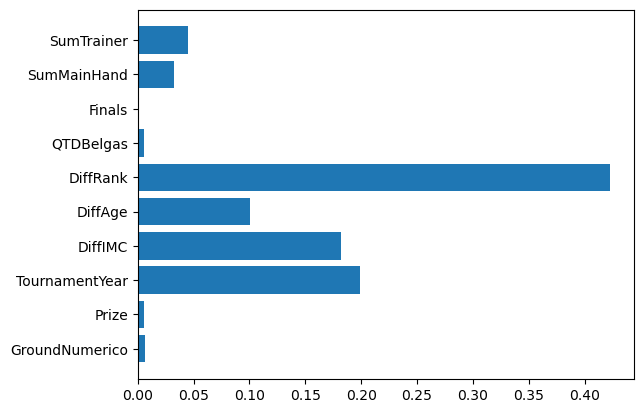

In [80]:
plt.barh(belgica_names, model.feature_importances_)